# AIML Assignment 2 Part B: Unsupervised Learning
## Background: The Decline of Retail Malls
You are the owner of a supermarket mall and through membership cards, you have
some basic data about your customers like Customer ID, age, gender, annual income
and spending score.

Spending Score is something you assign to the customer based on your defined
parameters like customer behaviour and purchasing data.

### Problem Statement
As the owner of the mall and you want to understand your customers so that
appropriate directions can be given to marketing team for them plan their strategy
accordingly.

By the end of this case study, you would be able to answer below questions:
- How to achieve customer segmentation using unsupervised machine learning
algorithm in Python?
- Who are your target customers with whom you can start marketing strategy?

#### What do we want to discover?
- The mall earns money from store rentals. This means that we want each store to be highly successful, and have a lot of customers.
- To help these shops gain customers, we can help by using our customer data to help perform targeted marketing.
- As a Mall, we offer several shops
    - Food (Food Courts, Fast Food Restaurant)
    - Groceries and Household Items (Supermarkets)
    - Appliances/Tech
    - Fashion (Shirts, Shoes, Dresses)
    - Cosmetics
    - Banking


- Our hope is to segment our customers into groups, and link them to shops that satisfy that group's needs.

##### What are the ways we can split up our customers into groups?
- Age: Teenagers, Young Adults, Adults (Parents?), Elderly
- Gender: Male, Female
- Income: Working Class, Middle Class, Upper Class
- Spending Habits: Frugal, High Spender

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# Statistical Analysis
from scipy import stats

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Pipelines
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering ,DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
sns.set()

## Data Ingestion
We will begin by loading in our data as a Pandas DataFrame. The first column is the index column, hence we will specify it when loading in the data.

In [2]:
df = pd.read_csv("Mall_Customers.csv", index_col=0)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## Exploratory Data Analysis

Before embarking on our customer segmentation task, we will take some time to explore the data, to gain a better understanding of our customer base.

### Dataset Features


| Features | Data Type | Description |
|---|---|---|
|Gender | Categorical | Either Male or Female |
| Age | Numerical (Discrete) | How old the customer is. |
| Annual Income (k$) | Numerical (Continuous) | Annual income in thousands (assume USD) |
| Spending Score (1-100) | Categorical (Ordinal) | Spending behaviour, a high spending score might indicate a customer who spends more money in the mall |




### General Data Characteristics

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


#### Initial Observations
- The data contains 4 features, and 200 observations.
- On first glance, there appear to be 0 missing values in the dataset.
- The first column is misnamed, it should be "Gender", not "Genre"
- Annual Income is in Thousands of Dollars. The integer data type suggests the annual income may have been rounded to the nearest thousand.
- Spending Score is a integer between 1 and 100.

#### Initial Data Cleaning
As we noted earlier, the first column is misnamed. Hence, we will take the liberty of renaming that column to "Gender".

In [4]:
df.rename(columns={"Genre" : "Gender"}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [6]:
df_eda = df.copy()

For our EDA, we will make a copy of the data. This let's us make changes to the data for exploration purposes without affecting the later clustering process.

### Univariate Data Analysis

#### Descriptive Statistics

In [8]:
df_eda.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


From the descriptive statistics, we note that:
- The mean age of 38.85 (approximately 39) is higher than the median age of 36, suggesting the distribution of age is positively skewed
- The typical customer of the mall is middle aged, as approximately 50% of all customers are between 28 and 49 years old
- The mean annual income is similar to the median annual income, suggesting the distribution is not significantly skewed.
- The mean spending is similar to the median spending score, suggesting that the distribution is not significantly skewed.
- Possible presence of outliers in the data.

#### Analysis of Gender
Gender could affect the type of items/services purchased in the mall. For instance, certain cosmestic stores in the mall may be tailored towards women. Hence, an understanding of the gender ratio in the mall can help inform the types of stores that may be more popular amongst customers.


In [9]:
df_eda['Gender'].value_counts() / len(df_eda)

Female    0.56
Male      0.44
Name: Gender, dtype: float64

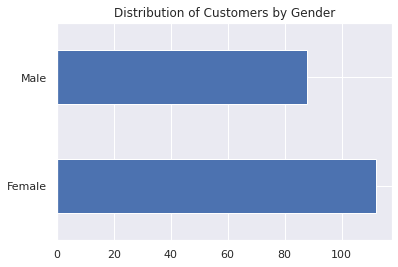

In [10]:
df_eda['Gender'].value_counts().plot(kind='barh', title='Distribution of Customers by Gender')
plt.show()

We observe that most of our customers are females (56% of customers). According to the [Ministry of Social and Family Development](https://www.msf.gov.sg/research-and-data/Research-and-Statistics/Pages/Singapore-Demographic-Sex-Ratio-Males-to-Females.aspx), in 2019 there were 957 males for every 1000 females (51% Females). Hence, the demographics of our mall appear to reflect societal demographics. 

Given the male-female ratio of the mall, it may be advantageous to ensure that there are anemenities and shops catered towards women in particular. 

In [11]:
df_eda['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

To check if the frequencies of each gender match up with the hypothesised gender ratio in Singapore, we perform a chi-square test, with a significance level of 5%. The null hypothesis is that the data has the hypothesised frequency.

In [12]:
percentage_female_sg = 1000 / (957 + 1000)
chi2, p = stats.chisquare([112, 88], [percentage_female_sg * len(df_eda), (1- percentage_female_sg) * len(df_eda)])
print("The p-value is", p)

The p-value is 0.16554720571618614


Since the p-value > 0.05, we fail to reject the null hypothesis. Thus it would appear that the gender ratio obtained is consistent with the gender ratio in Singapore's population.

#### Analysis of Age
Age can determine the stage of life of a person, affecting their spending power and habits. As such, it is important that we take note of the ages of our customers, to tailor to their specific needs at their stage in life.

<AxesSubplot:xlabel='Age', ylabel='Count'>

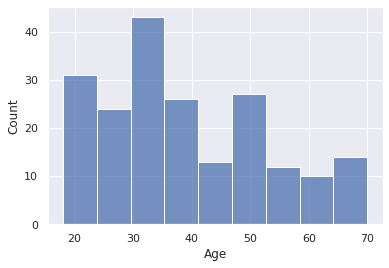

In [13]:
sns.histplot(data=df_eda, x='Age')

- As initially discovered from the descriptive statistics, we see that the age distribution is positively skewed, and that most customers are middle aged.

<AxesSubplot:xlabel='Age'>

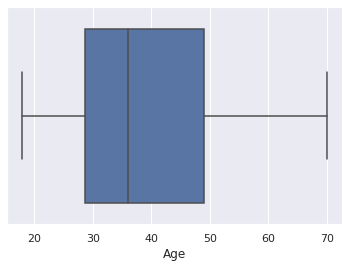

In [14]:
sns.boxplot(data=df_eda, x='Age')

- From the box plot, we see that there are no outliers for age.

<AxesSubplot:xlabel='Age', ylabel='count'>

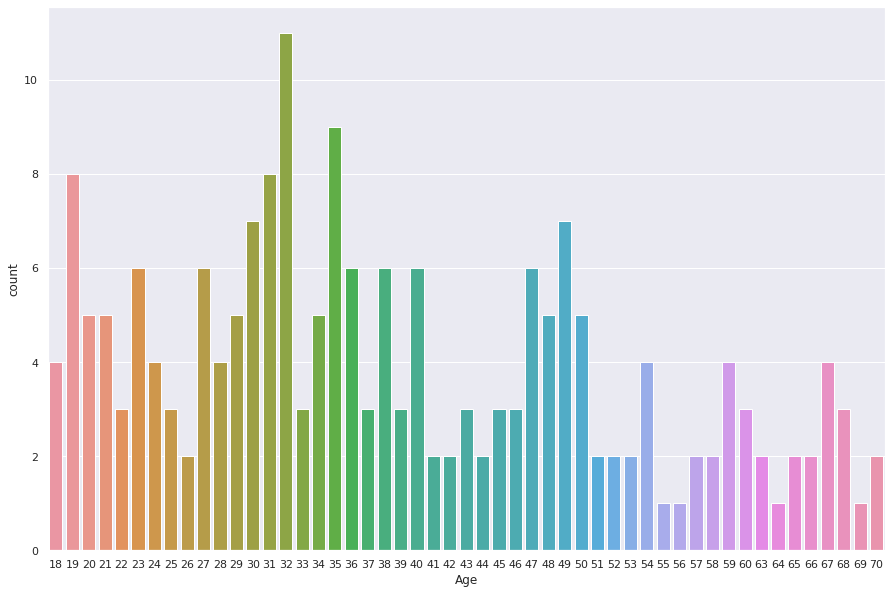

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x='Age', data=df_eda)

We also want a breakdown of the customers by their general age group. 

We define
- Young Adults as being 17 to 35
- Middle Age Adults as being 35 to 65 
- Eldery as being 65 and above

In [16]:
df_eda['Age Group'] = pd.cut(df_eda['Age'], [0, 35, 65, 100], labels=['Young Adult (17-35)', 'Middle Age (35-65)', 'Elderly (>65)'])
df_eda['Age Group']

CustomerID
1      Young Adult (17-35)
2      Young Adult (17-35)
3      Young Adult (17-35)
4      Young Adult (17-35)
5      Young Adult (17-35)
              ...         
196    Young Adult (17-35)
197     Middle Age (35-65)
198    Young Adult (17-35)
199    Young Adult (17-35)
200    Young Adult (17-35)
Name: Age Group, Length: 200, dtype: category
Categories (3, object): ['Young Adult (17-35)' < 'Middle Age (35-65)' < 'Elderly (>65)']

<AxesSubplot:xlabel='Age Group', ylabel='count'>

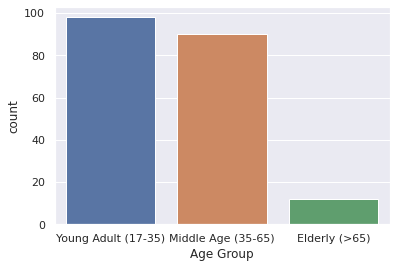

In [17]:
sns.countplot(data=df_eda, x='Age Group')

- Elderly are the least common type of customer
- Most customers are young adults

#### Annual Income

When looking at incomes, it may be useful to visualize the data in the form of Monthly income, hence I will create a Monthly Income attribute from the Annual Income attribute

In [18]:
df_eda["Monthly Income"] = df_eda["Annual Income (k$)"] / 12 * 1000

<AxesSubplot:xlabel='Annual Income (k$)', ylabel='Count'>

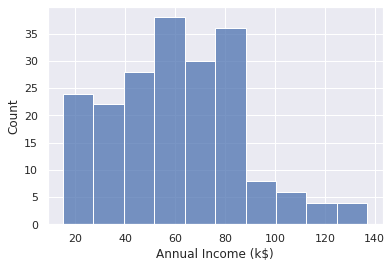

In [19]:
sns.histplot(data=df_eda, x='Annual Income (k$)')

<AxesSubplot:xlabel='Monthly Income', ylabel='Count'>

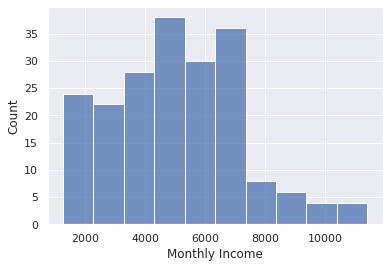

In [20]:
sns.histplot(data=df_eda, x='Monthly Income')

- We see that the majority of customers earn between $3000 to $7000 per month. 
- This is consistent with the average incomes of Singaporeans, which stands at around $5.7K per month ($68.4k annually)
- This suggest that most of our customers have a middle class background, as such wages would be typical of white collar jobs.
- We could potentially increase the spending power of our average customers by offering a buy now, pay later scheme, where they pay in interest free installments.
- There are a minority of customers that earn in excess of $90k per year, meaning that they have significant spending power.

<AxesSubplot:xlabel='Annual Income (k$)'>

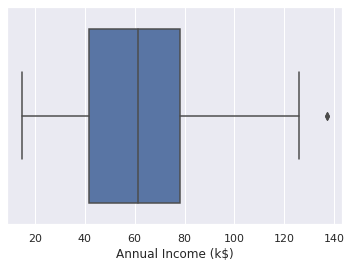

In [21]:
sns.boxplot(data=df_eda, x='Annual Income (k$)')

- We observe that we have a single outlier, who earns close to $140,000 annually (or close to $11k per month)

#### Spending Score

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Count'>

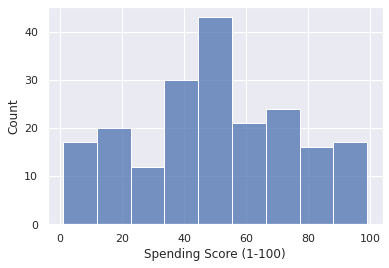

In [22]:
sns.histplot(data=df_eda, x='Spending Score (1-100)')

<AxesSubplot:xlabel='Spending Score (1-100)'>

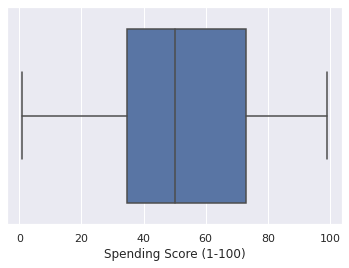

In [23]:
sns.boxplot(data=df_eda, x='Spending Score (1-100)')

- Most shoppers have spending scores between 35 and 70
- There are no customers with outlier spending scores.
- The distribution of spending scores is slightly positively skewed.

### Bi-variate Analysis

#### Is there strong evidence of a significant difference in average age, annual income or spending score between male and female customers?
Our dataset contains the Gender feature. In theory, customers of different genders may have different spending habits. For example, we might expect female customers to spend more money on cosmetics products, which are mainly targeted at females. This suggests that the feature may be useful.

However, the gender feature poses a few problems for our customer segmentation:
- Gender is a categorical variable. Even if encoded into a binary 1 and 0, certain clustering techniques (e.g. KMeans with Eucluidian distances) may not make sense, as the euclidian distance between Males and Females makes not sense at all. The resulting cluster center coordinate for Gender would also not make sense as well. This could be solved by using other clustering methods (e.g. K-Prototypes).
- We already have three other features. Hence, visualising the clustering would require us to visualise 4 dimensions (gender, age, spending, income, and the cluster labels). This means that we would have to drop one of other features if we want to use the Gender feature.

Hence, we want to determine if there is a significant difference between the demographics and habits of both genders. This may help us decide on a future course of action for what to do with the feature. To do this, we will perform a statistical two sample t-test on the means of both genders. 

In [24]:
df.pivot(columns='Gender')['Age']


Gender,Female,Male
CustomerID,,
1,NaN,19.0
2,NaN,21.0
3,20.0,NaN
4,23.0,NaN
5,31.0,NaN
...,...,...
196,35.0,NaN
197,45.0,NaN
198,NaN,32.0


In [25]:
def two_sample_t_test(data, col, level = 'Gender', equal_variances = True, significance_level = 0.05):
    pivoted_data = data.pivot(columns=level)[col]
    a, b = pivoted_data.iloc[:, 0].dropna(), pivoted_data.iloc[:, 1].dropna()
    text = f"Two Sample T-Test (assume {'' if equal_variances else 'no'} equal variances)\nH0 : Population means are equal\nH1 : Population means are not equal\nSignificance Level = {significance_level}"
    print(text)
    t_score, pvalue = stats.ttest_ind(a, b, equal_var=equal_variances)
    print("The p-value is", pvalue)
    if pvalue > significance_level:
        print("There is insufficient evidence to reject the null hypothesis that the population means are equal.")
    else:
        print("There is evidence to reject the null hypothesis that the population means are equal.")

In [26]:
df.groupby('Gender').var()

,Age,Annual Income (k$),Spending Score (1-100)
Gender,,,
Female,159.873150,676.621622,581.530808
Male,240.709378,709.602926,778.229754


We observe that the sample variances of both samples are similar, hence we will assume equal variances.

In [27]:
for col in ('Age', 'Annual Income (k$)', 'Spending Score (1-100)'):
    print(col)
    two_sample_t_test(df, col)
    print()

Age
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.3918907377882569
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Annual Income (k$)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.42755249399927864
There is insufficient evidence to reject the null hypothesis that the population means are equal.

Spending Score (1-100)
Two Sample T-Test (assume  equal variances)
H0 : Population means are equal
H1 : Population means are not equal
Significance Level = 0.05
The p-value is 0.4137446589852176
There is insufficient evidence to reject the null hypothesis that the population means are equal.



It appears that there are no significant differences between males and females.

In [28]:
df.groupby('Gender').corr()

Age  Annual Income (k$)  \
Gender                                                        
Female Age                     1.000000            0.059912   
       Annual Income (k$)      0.059912            1.000000   
       Spending Score (1-100) -0.375439            0.047542   
Male   Age                     1.000000           -0.092978   
       Annual Income (k$)     -0.092978            1.000000   
       Spending Score (1-100) -0.279628           -0.023684   

                               Spending Score (1-100)  
Gender                                                 
Female Age                                  -0.375439  
       Annual Income (k$)                    0.047542  
       Spending Score (1-100)                1.000000  
Male   Age                                  -0.279628  
       Annual Income (k$)                   -0.023684  
       Spending Score (1-100)                1.000000

### Summary of EDA

#### Distribution of Data

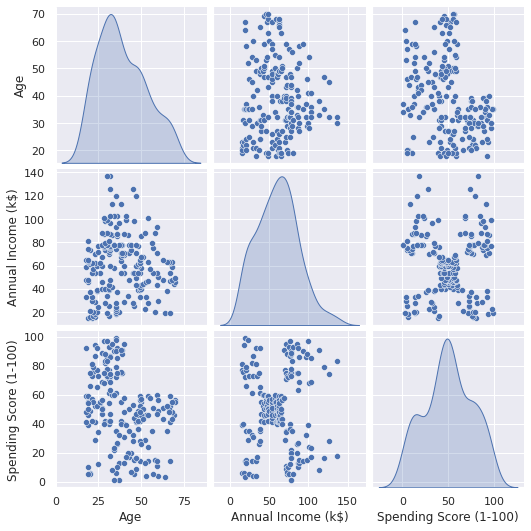

In [18]:
sns.pairplot(df_eda, diag_kind='kde')

#### Effect of Gender

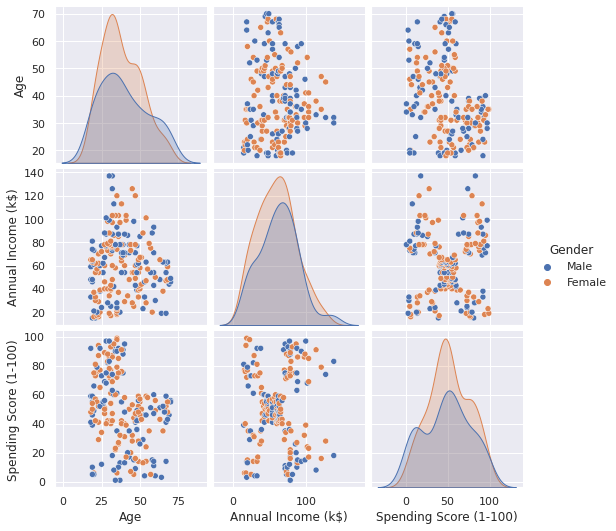

In [19]:
sns.pairplot(df_eda, diag_kind='kde', hue='Gender')

<ipython-input-23-0272ea36905f>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


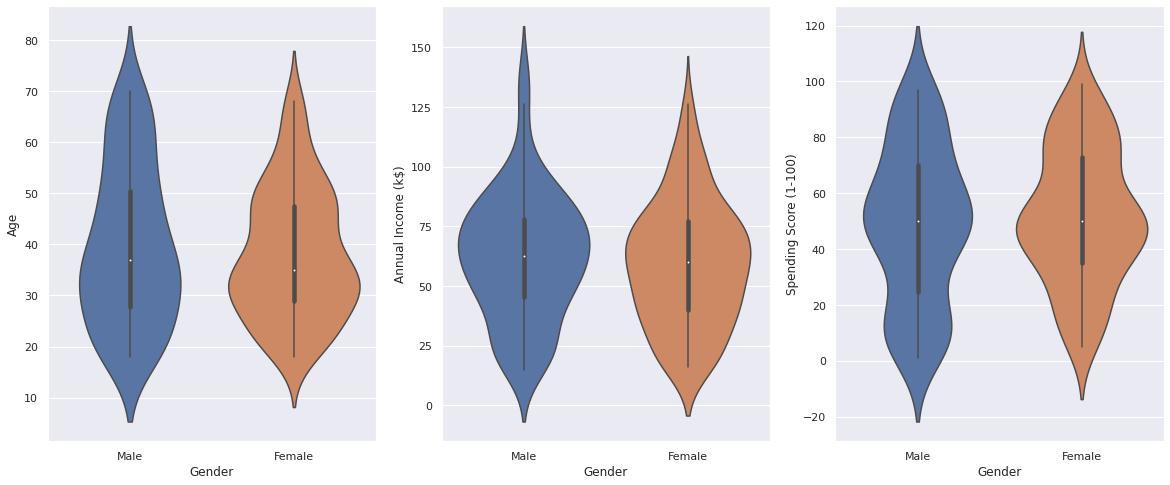

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for ax, col in zip(axes, df_eda.drop('Gender', axis=1).columns):
    sns.violinplot(data=df_eda, x='Gender', y=col, ax = ax)
fig.show()

## Data Pre-processing

Before clustering, we will do two things:
1. Standardize Our Data
2. Drop the Gender Feature

We will not standardize our data since our EDA has revealed that the data is on a similar scale.

From our statistical tests, and EDA, we observe no significant differences between the two genders. As a result, we decide to drop the feature entirely.

In [29]:
data = df.copy().drop('Gender', axis = 1)

## Clustering

### Utility Functions


In [68]:
def test_clusters(algo, data, n_range = range(2, 10)):
    figures = []
    models = []
    for n_clusters in n_range:
        try:
            model = algo(n_clusters=n_clusters)
        except:
            try:
                algo[-1].set_params(n_clusters=n_clusters)
            except:
                model = algo(n_components=n_clusters)
        cluster_labels = model.fit_predict(data)
        models.append(model)
        figure, _ = plot_silhouette(cluster_labels, data, n_clusters)
        figures.append(figure)
    return figures, models

In [31]:
# Credit, code modified from: https://chart-studio.plotly.com/~Diksha_Gabha/2853.embed#:~:text=The%20silhouette%20plot%20displays%20a,of%20%5B%2D1%2C%201%5D.
def plot_silhouette(cluster_labels, data, n_clusters):
    avg_silhouette = silhouette_score(data, cluster_labels) # avg_silhouette gives us a measure of overall clustering quality
    print(f"Average Silhouette Score for {n_clusters} clusters: {avg_silhouette}")
    sample_silhouette_values = silhouette_samples(data, cluster_labels) # calculate silhouette scores for individual samples
    fig = make_subplots(rows=1, cols=2, print_grid=False, subplot_titles=('Silhouette Scores (by Clusters) Plot', 'Scatterplot of Clustering'), specs=[[{'type':'xy'}, {'type':'scene'}]])
    fig['layout']['xaxis1'].update(title='Silhouette Coefficient')
    fig['layout']['yaxis1'].update(title='Cluster Label', showticklabels=False, range=[0, len(data) + (n_clusters + 1) * 10])
    fig.update_scenes(dict(
        xaxis_title = 'Age',
        yaxis_title = 'Annual Income (k$)',
        zaxis_title = 'Spending Score (1-100)'
    ))
    y_lower = 10
    for i in range(n_clusters):
        cluster_silhouettes = sample_silhouette_values[cluster_labels == i]
        cluster_silhouettes.sort()
        cluster_size = cluster_silhouettes.shape[0]
        y_upper = y_lower + cluster_size
        #colors = cm.get_cmap("Spectral")
        colors = sns.color_palette('tab10')
        c = f'rgb({colors[i][0] * 255}, {colors[i][1] * 255}, {colors[i][2] * 255})'
        filled_area = go.Scatter(y=np.arange(y_lower, y_upper), x=cluster_silhouettes, mode='lines', showlegend=False, line=dict(width=0.5, color=c), fill='tozerox')
        y_lower = y_upper + 10
        fig.append_trace(filled_area, 1, 1)
    avg_line = go.Scatter(x=[avg_silhouette] * 500, y=np.arange(500), showlegend=False, mode='lines', line=dict(color='red', dash='dash', width=1), fill='tozeroy')
    fig.append_trace(avg_line, 1, 1)
    cmap = dict(zip(np.sort(np.unique(cluster_labels)), colors))
    scatter = go.Scatter3d(x = data['Age'], y=data['Annual Income (k$)'], z=data['Spending Score (1-100)'], mode='markers', marker=dict(color=list(map(lambda x : tuple(np.array(cmap[x]) * 255), cluster_labels))))
    fig.append_trace(scatter, 1, 2)
        
    return fig, avg_silhouette

In [32]:
def show_silhouette(fig, n_clusters, min_n_clusters=2):
    return fig[n_clusters - min_n_clusters]

In [33]:
def scree_plot(algo, n_clusters_max = 12, n_clusters_min = 2, figsize=(10, 8)):
    n = list(range(n_clusters_min, n_clusters_max + 1))
    fig, ax = plt.subplots(figsize=figsize)
    inertia = []
    cluster_per_n = []
    for no_cluster in n:
        model = algo(n_clusters=no_cluster)
        clusters = model.fit_predict(data)
        cluster_per_n.append(clusters)
        inertia.append(model.inertia_)
    ax.plot(n, inertia, 'o-')  
    ax.set_title("Scree Plot")
    ax.set_ylabel('Inertia')
    ax.set_xlabel('n_clusters')

In [34]:
def get_cluster_labels(models, data, n_clusters, min_n_clusters=2):
    try:
        labels = models[n_clusters-min_n_clusters].predict(data)
    except:
        labels = models[n_clusters-min_n_clusters].fit_predict(data)
    return labels

### KMeans

#### Selecting the Number of Clusters

##### Scree Plot

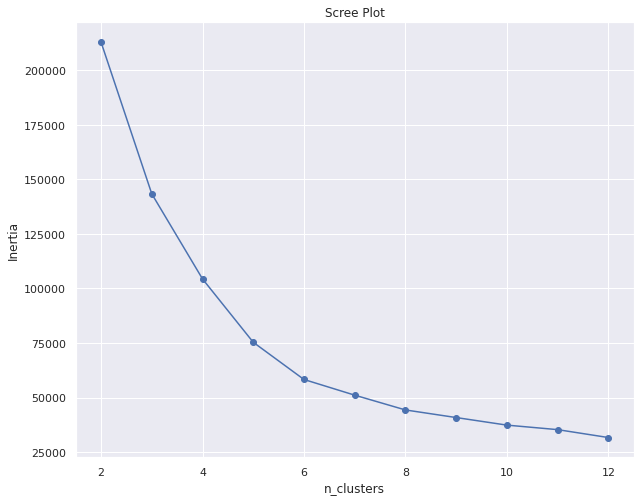

In [35]:
scree_plot(KMeans)


From the elbow plot, we see that the elbow is between 4 and 6.

##### Silhouette Analysis
Silhouette analysis can be used to help determine the optimal number of clusters for a clustering task. We use a silhouette plot to display a measure (ranging from -1 to 1) of how close each point in one cluster is to points in neighbouring clusters. 

Silhouette coefficients near 1 indicate the sample is far away from the neighbouring clusters. 0 indicates the sample is very close to the boundary between two clusters and a value less than 0 indicates a sample that may be wrongfully clustered.

In [36]:
figures, models = test_clusters(KMeans, data)

Average Silhouette Score for 2 clusters: 0.293166070535953
Average Silhouette Score for 3 clusters: 0.3839349967742105
Average Silhouette Score for 4 clusters: 0.40546302077733304
Average Silhouette Score for 5 clusters: 0.44446409171786105
Average Silhouette Score for 6 clusters: 0.4523566166018854
Average Silhouette Score for 7 clusters: 0.4412807576186172
Average Silhouette Score for 8 clusters: 0.42790288922594905
Average Silhouette Score for 9 clusters: 0.38843012647898517


The number of clusters with the highest silhouette plot is 6

In [37]:
show_silhouette(figures, 6)

Hence, from both the elbow and silhouette score, we have a range between 4 to 6. We will need to take a look at the clusters obtained to see which number of clusters gives us the best segmentation.

#### Visualising the Clusters Obtained

##### 4 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

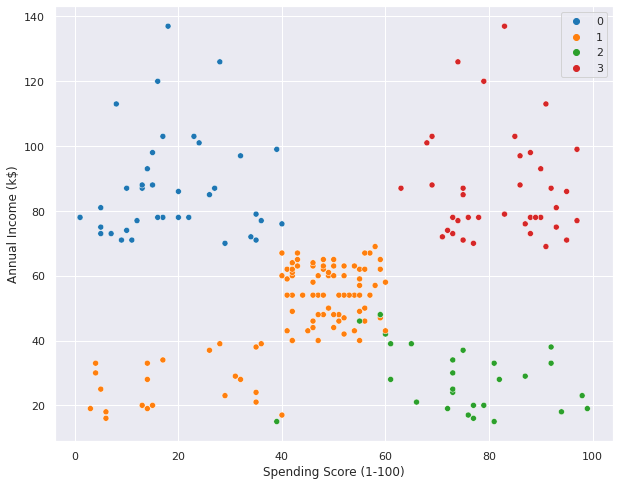

In [38]:
cluster_labels = get_cluster_labels(models, data, 4)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

When we have four clusters, we see that some of the clusters are not as well defined as they could be. For example, in Cluster 0, we see that some points fall far away from where most of the points lie, seeming to form their own cluster.

In [39]:
show_silhouette(figures, 4)

- The silhouette plot shows:
    - the cluster sizes for each cluster are uneven, as some clusters are smaller
    - the fourth cluster (in red) is the largest cluster
    - the fourth cluster (red) is the least well defined clusters, as almost all points inside the cluster have a lower than average silhouette coefficient. In fact, there are a few points inside that cluster with a negative silhouette coefficient, suggesting that they are in the wrong cluster.
- in general, the clustering obtained is poor as the fourth cluster is poorly defined. This can also be seen by a visual inspection of the clusters. While the other clusters appear distinct from one another, the red cluster seems to have two inner clusters forming it: one for medium income people of moderate spending power, and another for low income people with low spending power

##### 5 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

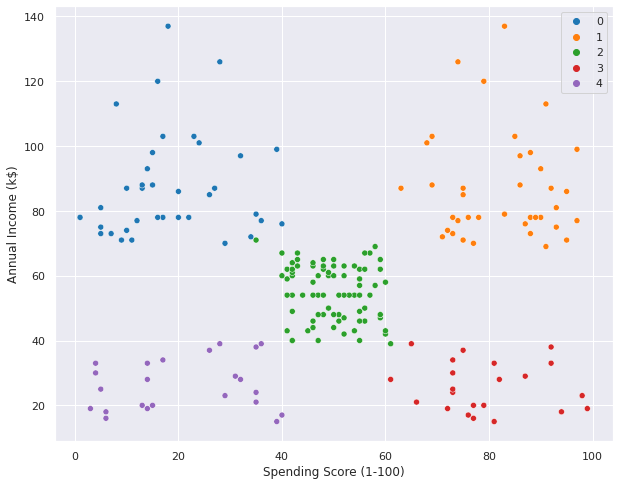

In [40]:
cluster_labels = get_cluster_labels(models, data, 5)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

When we have five clusters, we note that cluster 3 is not as well defined as it could be, as it seems to mix with cluster 2.

In [41]:
show_silhouette(figures, 5)

- From the silhouette plot we observe that:
    - the cluster sizes are uneven, as some clusters (e.g blue and red) are small, while the orange and purple clusters are larger
    - this time, most clusters have most of their points being above the average silhouette score (which is also 0.04 higher than with 4 clusters), meaning the clusters are more well defined
    - the red cluster is the most well defined, as it appears that all of the points there have a high silhouette score
    - the least well defined clusters are the orange cluster, where less than half of points inside it have an above average silhouette coefficient, with some points having negative silhouette scores

- Visually:
    - there is some overlap between the orange and red cluster
        - the orange cluster represents people of all ages who are middle income and have a moderate spending score
        - the red cluster represents young people who are low-middle income with moderate to high spending scores
        - thus, there is some overlap for young people who are just below middle income and have moderate spending scores, causing the orange cluster to not be as well defined.
    - there is also some overlap between the orange and green cluster:
        - the green cluster represents people of above average income who spend frugally
        - the overlap comes with people who are just above average, and who have a moderate spending score, which are very close to the orange cluster

##### 6 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

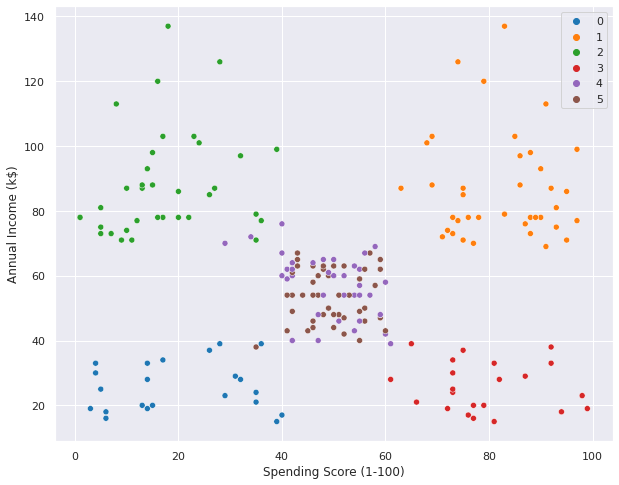

In [42]:
cluster_labels = get_cluster_labels(models, data, 6)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

- Looking at the 2D plot, we see that the new cluster goes over the cluster in the middle, suggesting that it is seperated by age

In [43]:
show_silhouette(figures, 6)

- From inspecting the silhouette plot, we note:
    - The clusters are more evenly formed now, with clusters having similar sizes
    - There has been a marginal improvement in the average silhouette score, but not by much
    - The most well defined cluster appears to be the brown cluster, followed by the purple cluster
    - The least well defined clusters are the red, green and orange clusters, with the green and orange clusters being the least well defined.
    - The red cluster has two points which have a negative silhouette score (suggesting they are misclassified)
- A visual inspection of the clusters formed shows:
    - there is some overlap between the red and orange/green clusters:
        - the red cluster represents people of above average income who spend frugally
        - the overlap comes with people who are just above average, and who have a moderate spending score, which are very close to the orange/green cluster

##### 7 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

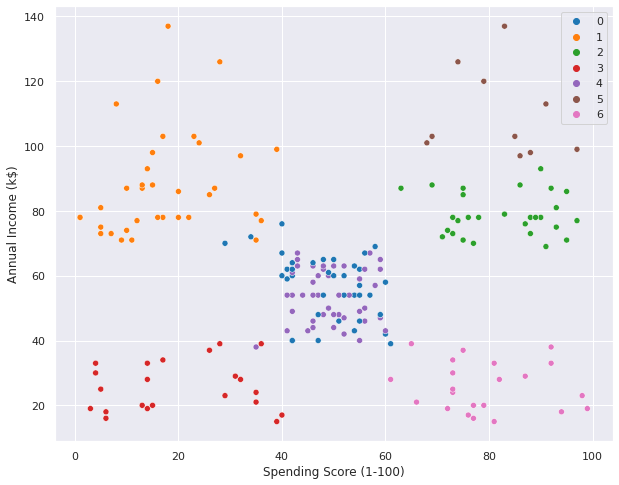

In [44]:
cluster_labels = get_cluster_labels(models, data, 7)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

In [45]:
show_silhouette(figures, 7)

- WIP

#### Final KMeans Clustering

Based on our analysis of the inertia, silhouette scores and visualisation of clusters, it seems that the best choice is between 5 and 6 clusters. While both are similar, an advantage the 6th cluster brings is in terms of interpretation: the new cluster seperates the middle income spenders by their age

Even with similar spending scores, these people may not be spending on the same services, so seperating by age can help improve the recommendations formed.

Now, we will analyse the clustering, and give our insights and interpretations.

In [46]:
cluster_labels = get_cluster_labels(models, data, 6)
model = models[6 - 2]
cluster_centers = pd.DataFrame(model.cluster_centers_, columns=data.columns)
cluster_centers['Cluster Size (% of Total)'] = pd.Series(cluster_labels).value_counts() / len(cluster_labels) * 100
cluster_centers

,Age,Annual Income (k$),Spending Score (1-100),Cluster Size (% of Total)
0,44.318182,25.772727,20.272727,11.0
1,32.692308,86.538462,82.128205,19.5
2,41.685714,88.228571,17.285714,17.5
3,25.272727,25.727273,79.363636,11.0
4,27.000000,56.657895,49.131579,19.0
5,56.340909,53.704545,49.386364,22.0


In [47]:
px.scatter_3d(data_frame=cluster_centers, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)', color=cluster_centers.index)

##### Interpretation
###### What do the clusters mean?

Below is a summary of the clusters, based off the cluster centers produced by K-Means
| Cluster Number | Age | Annual Income | Spending Score | Cluster Size |
|---|---|---|---|---|
|0| Middle Age | Low Income | Low Spending | Small |
|1| Old Age | Middle Income | Average Spending | Large |
|2| Young Age | Middle Income | Average Spending | Large |
|3| Middle Age | High Income | Low Spending | Medium |
|4| Young-Middle Age | High Income | High Spending | Large |
|5| Young Age | Low Income | High Spending | Small |

Group Zero ('The Working Class')
> This group of people is mostly comprised of middle aged to elderly people, who do not earn much. Consequently, they tend to be more frugal with their spending, resulting in them having lower spending scores. It is likely then that most of their spending are for daily necessities

Group One ()
> This group of people are in their fifties and above, who earn a moderate income, and have an average spending score.

###### Interpretation
Group Zero ('The Elderly Poor')
> This group is of middle aged to elderly people. Their low z-scores for incomes and spending suggests that they are the elderly poor. They retired without much money, but do not have many needs. It is likely that their purchases in the mall are for daily necessities, and hence any targeted approach towards them should involve enticing them to places like supermarkets, food courts, etc.

Group One ('Executives and Parents')
> This group is of working adults in their 30s. These white collar workers are in the peak of their careers and hence have a lot of spending power. Due to their spending power, we observe that this group has a high spending score. This may be due to them starting up families or simply to fufill their needs and desires. We should try and target this group, and drive them towards high-spending: e.g. Luxury Goods, Appliances

Group Two ('Young Workers')
> This group is of young adults. As they are early in their careers, they lack significant spending power (as shown by their slightly below average income). As a result, they tend to be more thrifty as shown by their below average spending score. We should target this group with good deals and discounts, and try to undercut other malls.

Group Three ('The Comfortably Retired')
> These customers are extremely old, and have retired comfortably. Although they are no longer working, they still have some spending power (much more compared to the 'Elderly Poor') as they likely did better in their past careers and thus have investments. Due to their old age, they do not have a heavy expenditure, and so have a similar spending score to the Young Workers. 

Group Four 
> These customers are in a similar age to the executives, people in their 30s/40s. They have similar spending power to them, but seemingly choose not to spend much in the mall (they have the lowest spending score out of the 6 clusters). This suggests that they are thinking ahead, and could be using their incomes to invest in their retirement (or simply buying from online stores). This group has a lot of untapped potential if we can convince them to spend more money in the mall. 

Group Five ('The Young and Irresponsible')
> This is the youngest group, and have the least spending power. This may be due to having to pay for education (student debt) and/or being early in their careers. In spite of that, they have large spending scores, suggesting that they are high spenders. This may signal a lack of financial maturity, and hence are more easily susceptible to targeted marketing. 

### Hierarchical Clustering

#### Selecting the Number of Clusters

In [48]:
h_clust = AgglomerativeClustering(compute_distances=True, compute_full_tree=True)
h_clust.fit(data)

AgglomerativeClustering(compute_distances=True, compute_full_tree=True)

In [49]:
counts = np.zeros(h_clust.children_.shape[0])
n_samples = len(h_clust.labels_)
for i, merge in enumerate(h_clust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage = np.column_stack([h_clust.children_, h_clust.distances_, counts]).astype(float)

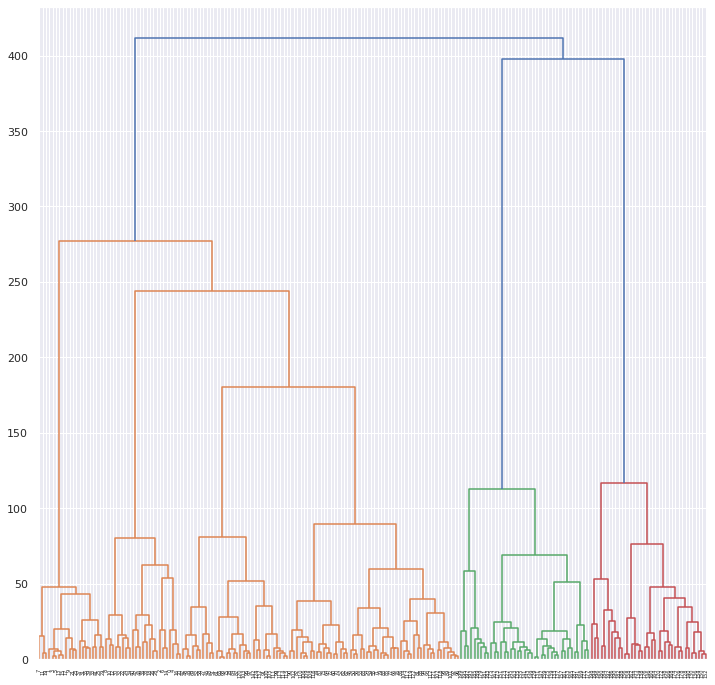

In [50]:
fig, ax = plt.subplots(figsize=(12, 12))
dendrogram(linkage)
plt.show()

The dendrogram is a diagram that shows how clusters are formed in the hierarchical clustering.  The height of each branch on the dendrogram tells us how similar the leaves are to each other. 
To use a dendrogram to select the optimal number of clusters, we want to draw a line that will cut through the dendrogram horizontally. We want to cut the dendrogram such that we minimise the vertical distance (that is, each cluster should have points that are highly similar to each other), while not having too many clusters (so we should not cut the dendrogram right at the bottom)
From the dendrogram, a good number of clusters would be 6-8 clusters, as after 6 clusters, the remaining clusters are all highly dissimilar, and hence it does not make sense to merge them.

Thus, to futher narrow down our clustering, we will calculate the silhouette score, and visually inspect the clusters created.

In [53]:
figures_hclust, models_hclust = test_clusters(AgglomerativeClustering, data)

Average Silhouette Score for 2 clusters: 0.2992593203550994
Average Silhouette Score for 3 clusters: 0.38141795042544546
Average Silhouette Score for 4 clusters: 0.41037986351850747
Average Silhouette Score for 5 clusters: 0.4401889024290193
Average Silhouette Score for 6 clusters: 0.44308912983504156
Average Silhouette Score for 7 clusters: 0.4262301125101286
Average Silhouette Score for 8 clusters: 0.41028404899198817
Average Silhouette Score for 9 clusters: 0.3663955117052502


- We see that the optimal number of clusters appears to be between 5 and 6

##### 5 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

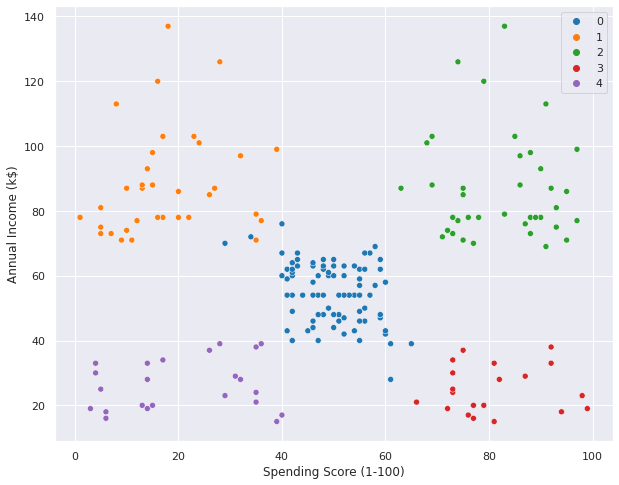

In [54]:
cluster_labels = get_cluster_labels(models_hclust, data, 5)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

In [55]:
show_silhouette(figures_hclust, 5)

##### 6 Clusters

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Annual Income (k$)'>

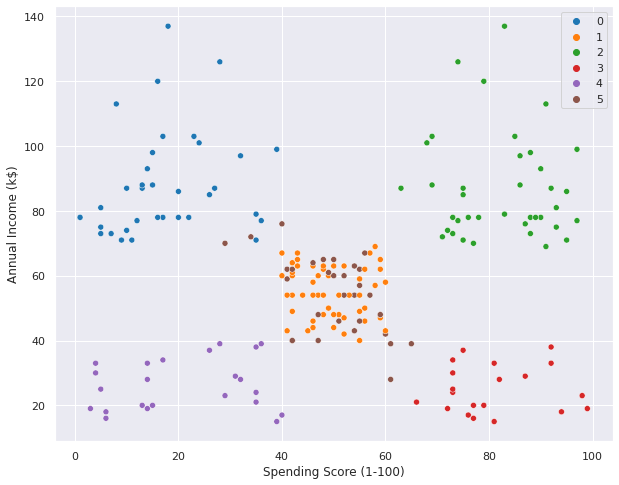

In [56]:
cluster_labels = get_cluster_labels(models_hclust, data, 6)
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=data, x='Spending Score (1-100)', y='Annual Income (k$)', hue=cluster_labels, palette='tab10')

In [57]:
show_silhouette(figures_hclust, 6)

### DBSCAN

In [58]:
nearest_n = NearestNeighbors(n_neighbors=3).fit(data)

distance, idx = nearest_n.kneighbors(data)
distance = np.sort(distance, axis=0)[:, 1]

grads = np.gradient(distance)
eps = distance[np.argmax(grads)]
eps

19.748417658131498

In [59]:
model = DBSCAN(eps=eps).fit(data)
fig, sil = plot_silhouette(model.labels_, data, len(np.unique(model.labels_)))
fig

Average Silhouette Score for 2 clusters: 0.3588158894405232


In [60]:
results = []
for eps in np.logspace(1, 2, 100):
    model = DBSCAN(eps=eps).fit(data)
    try:
        fig, sil = plot_silhouette(model.labels_, data, len(np.unique(model.labels_)))
        results.append({
            'score' : sil,
            'eps': eps
        })
    except:
        pass

Average Silhouette Score for 5 clusters: 0.15212635871472988
Average Silhouette Score for 5 clusters: 0.17347247827454523
Average Silhouette Score for 6 clusters: 0.14780003400502686
Average Silhouette Score for 6 clusters: 0.14780003400502686
Average Silhouette Score for 6 clusters: 0.1596939430611063
Average Silhouette Score for 7 clusters: 0.2042311686234455
Average Silhouette Score for 7 clusters: 0.21156364147287732
Average Silhouette Score for 6 clusters: 0.145784128646343
Average Silhouette Score for 6 clusters: 0.1759177615505368
Average Silhouette Score for 5 clusters: 0.23170713241201668
Average Silhouette Score for 5 clusters: 0.2361832552676676
Average Silhouette Score for 5 clusters: 0.25403926785302217
Average Silhouette Score for 4 clusters: 0.21984831941644578
Average Silhouette Score for 4 clusters: 0.22415399955841486
Average Silhouette Score for 4 clusters: 0.22155522896085952
Average Silhouette Score for 3 clusters: 0.2695999989490317
Average Silhouette Score for 3 

In [61]:
sorted_scores = sorted(results, key=lambda x : -x['score'])
sorted_scores[0]

{'score': 0.39088488327271015, 'eps': 22.051307399030456}

In [62]:
model = DBSCAN(eps=sorted_scores[0]['eps']).fit(data)
ig, sil = plot_silhouette(model.labels_, data, len(np.unique(model.labels_)))
fig

Average Silhouette Score for 2 clusters: 0.39088488327271015


We conclude that DBSCAN is a poor choice of clustering algorithm.

### Gaussian Mixture Model

In [69]:
figures, models = test_clusters(GaussianMixture, data)

Average Silhouette Score for 2 clusters: 0.2472911228729811
Average Silhouette Score for 3 clusters: 0.37496527429495236
Average Silhouette Score for 4 clusters: 0.3776529904023892
Average Silhouette Score for 5 clusters: 0.4270889648645593
Average Silhouette Score for 6 clusters: 0.41411324921477655
Average Silhouette Score for 7 clusters: 0.41315394530870486
Average Silhouette Score for 8 clusters: 0.39831508916599007
Average Silhouette Score for 9 clusters: 0.34548438974614515


In [70]:
show_silhouette(figures, 5)

## Improving the Results of Clustering

### Feature Scaling

### Hyperparameter Tuning

### Ensemble Clustering

One possible way to improve the result of clustering is to attempt to perform ensemble clustering. One simple method is to create multiple models, and allow them to vote on what cluster a point belongs to. Each cluster formed by the clustering algorithm must generally correspond to the same area.

In [1]:
cluster_mapping = {
    "KMeans" : {
        i : i for i in range(6)
    },
    "HClust" : {

    },
    "GMM" : {

    }
}